# **Data project**
***

# Introduction

This data project addresses the development of home care for the elderly in Denmark. The main focus of the project will be on people aged 65 years and above. The project will look at the number of referral hours to home care in total and divided into whether the recipients have chosen a private or a public supplier. It is a known fact that the share of elders has been growing for the last decade, but at the same time, the number of referral hours to home care has been decreasing. Whether the decreasing number is due to the elderly generally needing less help with personal care and practical tasks or a down-prioritization by the public sector is an interesting discussion, but will remain out of the scope for this project. 

In Denmark, it is the responsibility of the public sector to take care of the elderly, including providing home care for both personal care and practical tasks. The majority of the public services for the elderly are controlled by the state but supplied by the municipalities. The municipalities can outsource home care to private contractors, who need to live up to a certain level of quality and price. In the end, it is the elderly that choose which supplier they wish to receive help from.

The data project uses data from Statistics Denmark. Table AED06 shows total recipients referral to home care and hours per week. Table AED12 shows the share of home care provided by private contractors. These two tables can be used to find the number of recipients referral to home care and the number that choose a public/private supplier. Furthermore, table BY2 is used to get data on the entire population. 

The data project is organized as follows. Section 3 describes the import, cleaning and structuring of the data used in the project. Section 4 presents a graphical analysis and a map, and lastly, section 5 concludes on the project.

# Data import, cleaning and structuring

## Importing relevant packages

Importing useful packages for the project: 

In [37]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets

As already mentioned, we are going to use data from Statistics Denmark. Instead of going to their website to download their data in Excel format and then import it to Python, we choose to use an API (Application Programming Interface) to fetch the data. 

In [38]:
# importing a package that allow to extract data from Statistics Denmark (DST) 
import pydst
dst = dst = pydst.Dst(lang='en')

In [39]:
# importing a package that allow to make a map of Denmark
import geopandas as gpd

*Note, that the two packages* `pydst` *and* `geopandas` *are not default packages in python, and hence, one need to install those in order to be able to run the code in this notebook.*

- *To install* `pydst` (works for both windows and mac)*: open terminal and run the command: pip install git+https://github.com/elben10/pydst*
- *To install* `geopandas`: 
    - *Windows: open terminal and run the command: conda install -c conda-forge geopandas*
    - *Mac: open terminal*
        1. Run the command: conda install -c conda-forge geopandas
        2. Uninstall fiona by running the command: conda uninstall fiona
        3. Download fiona wheel and install: can be downloaded from here (https://pypi.python.org/packages/71/ea/908bf078499b30d1ec374eb5baba016a568fc8142ee6ccf72e356d20871c/Fiona-1.7.4-cp27-cp27m-macosx_10_6_intel.whl#md5=971393c23ffc552664b7c694b992fb3e) and run: pip install Fiona-1.7.4-cp27-cp27m-macosx_10_6_intel.whl
        4. Reinstall geopandas by running the command: pip install git+git://github.com/geopandas/geopandas.git
        
**NOTE: We only use `geopandas` to make it easier to compare municipalities at a given point in time. We have another interactive figure (that do not require `geopandas`) where it is possible to see the development over time in each of municipality. Comparing the level across municipalities is also possible, but not as easy**

## Importing data on referral hours from Statistics Denmark

The first step is to import the relevant data. We need information on the total, public and private referral hours to home care. Statistics Denmark has a data set including total referral hours to home care (AED06) and a data set including the shar of privately provided referral hours (AED12).

We start by getting an overview of the variables by using the `get_variables()`. The function lists all the values that can be attained in the desired table "*Recipients referral to home care, free choice, by region, type of benefits, hours per week, age and sex (2008-2017)*" (AED06). It can also be found here: http://statistikbanken.dk/statbank5a/default.asp?w=1368. 

In [4]:
# importing total referral hours
totalhours_vars = dst.get_variables(table_id = 'AED06')
totalhours_vars

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,True,YDELSESTYPE,NaN,type of benefits,False,"[{'id': '100', 'text': 'Permanent home help, t..."
2,True,TIMEUGE,NaN,hours per week,False,"[{'id': '050', 'text': 'Total duration'}, {'id..."
3,True,ALDER,NaN,age,False,"[{'id': '050', 'text': 'Total'}, {'id': '100',..."
4,True,KOEN,NaN,sex,False,"[{'id': '100', 'text': 'Males and women, total..."
5,False,Tid,NaN,time,True,"[{'id': '2008', 'text': '2008'}, {'id': '2009'..."


Now, the same approach is taken to get an overview of the table: "*Recipients referral to home care, free choice, who use private contractor by region, type of benefits, age and sex (2008-2017)*" (AED12). 

In [5]:
# importing the share of privately provided referral hours
privateshare_vars = dst.get_variables(table_id = 'AED12')
privateshare_vars

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,True,YDELSESTYPE,NaN,type of benefits,False,"[{'id': '100', 'text': 'Permanent home help, t..."
2,True,ALDER,NaN,age,False,"[{'id': '050', 'text': 'Total'}, {'id': '100',..."
3,True,KOEN,NaN,sex,False,"[{'id': '100', 'text': 'Males and women, total..."
4,False,Tid,NaN,time,True,"[{'id': '2008', 'text': '2008'}, {'id': '2009'..."


## Cleaning and structuring data on referral hours

In order to fetch the data we use `get_data()`. The function allows us to choose the desired variables from the original table, and further restrict the data on several conditions listed below.  
With data from table AED06 containing total referral hours to home care, we generate two dataframes. Common for both of them is that we restrict it to only include *Permanent home help, total* (100), which states the total number of referral hours to home care per week. In order to find the underlying value of *Permanent home help, total* we use a function that extracts the second element of the variable *values* from the data set *totalhours_vars*. This is found to be 100, which can be seen in the output below. 

In [6]:
totalhours_vars['values'][1]

[{'id': '100', 'text': 'Permanent home help, total'},
 {'id': '200', 'text': 'Personal care'},
 {'id': '300', 'text': 'Help on necessary practical duties'},
 {'id': '400',
  'text': 'Both personal care and help on necessary practical duties'}]

Using the method we restrict the data to include ages *65 years and above* (200-800) and both *men and women* (100). For one of the two dataframes we only keep the country level (000) and for the other, we only keep the municipality level (i.e. we remove observations on country and regional level). The time period is restricted to 2010-2017. We also rename a few of the variables and remove missing observations for some municipalities. Lastly, we convert our variables of interest, namely the hours of home care to a numeric variable. 

In [7]:
# a. defining dictionary to rename variables
col_dict1 = {} 
col_dict1['TID'] = 'year'
col_dict1['INDHOLD'] = 'home_help_total'
col_dict1['OMRÅDE'] = 'geo_area'
col_dict1['ALDER'] = 'age'

# b. load data 
totalhours_denmark = dst.get_data(table_id = 'AED06', variables={'OMRÅDE':['000'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 'KOEN':['100'], 
                                                      'Tid':['2010','2011','2012','2013','2014','2015','2016','2017']})
totalhours_municipality = dst.get_data(table_id = 'AED06', variables={'OMRÅDE':['*'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 'KOEN':['100'], 
                                                      'Tid':['2010','2011','2012','2013','2014','2015','2016','2017']})

# c. renaming and dropping variables
totalhours_denmark.rename(columns=col_dict1, inplace=True)
totalhours_denmark.drop(['YDELSESTYPE', 'KOEN', 'TIMEUGE'], axis=1, inplace=True)

totalhours_municipality.rename(columns=col_dict1, inplace=True)
totalhours_municipality.drop(['YDELSESTYPE', 'KOEN', 'TIMEUGE'], axis=1, inplace=True)

# d. removing missing observations 
totalhours_municipality = totalhours_municipality[totalhours_municipality.home_help_total !=".."]

# e. removing observations on country and regional level in the municipality dataset
for val in ['Region', 'All Denmark']: 
    I = totalhours_municipality.geo_area.str.contains(val)
    totalhours_municipality = totalhours_municipality.loc[I == False] 

# f. convert values to numeric
totalhours_denmark.home_help_total=totalhours_denmark.home_help_total.astype('float')
totalhours_municipality.home_help_total=totalhours_municipality.home_help_total.astype('float')

# g. multiplying with 52 as there is 52 weeks in a year
totalhours_denmark.home_help_total=totalhours_denmark.home_help_total*52
totalhours_municipality.home_help_total=totalhours_municipality.home_help_total*52

Now, the data set for all Denmark on the total referral hours to home care looks like the table below:

In [10]:
totalhours_denmark.head(5)

,geo_area,age,year,home_help_total
0,All Denmark,65-66 years,2010,240245.2
1,All Denmark,67-69 years,2010,393052.4
2,All Denmark,70-74 years,2010,858431.6
3,All Denmark,75-79 years,2010,1370163.6
4,All Denmark,80-84 years,2010,1873320.8


And likewise, the data set for the total referral hours to home care on the municipality level looks like the table below:

In [11]:
totalhours_municipality.head(5)

,geo_area,age,year,home_help_total
0,Egedal,67-69 years,2010,1944.8
1,Egedal,70-74 years,2010,4487.6
2,Egedal,75-79 years,2010,6474.0
3,Egedal,80-84 years,2010,6630.0
4,Egedal,85-89 years,2010,4264.0


The same approach is taken for the data from AED12 containing the private share of referral hours to home care. We generate two dataframes, where we restrict both of them to only include *the fraction of privately supplied home care* (100), only ages *65 years and above* (200-800) and both *men and women* (100). For one of the two dataframes we only keep the country level (000) and for the other, we only keep the municipality level (i.e. we remove observations on country and regional level). The time period is restricted to 2010-2017. We also rename a few of the variables and remove missing observations for some municipalities. Lastly, we convert our variables of interest, namely the hours of home care to a numeric variable. 

In [12]:
# a. defining dictionary to rename variables
col_dict2 = {} 
col_dict2['TID'] = 'year'
col_dict2['INDHOLD'] = 'frac_private'
col_dict2['OMRÅDE'] = 'geo_area'
col_dict2['ALDER'] = 'age'

# b. load data 
privateshare_denmark = dst.get_data(table_id = 'AED12', variables={'OMRÅDE':['000'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 'KOEN':['100'], 
                                                      'Tid':['2010','2011','2012','2013','2014','2015','2016','2017']})
privateshare_municipality = dst.get_data(table_id = 'AED12', variables={'OMRÅDE':['*'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 'KOEN':['100'], 
                                                      'Tid':['2010','2011','2012','2013','2014','2015','2016','2017']})

# c. renaming and dropping variables
privateshare_denmark.rename(columns=col_dict2, inplace=True)
privateshare_denmark.drop(['YDELSESTYPE', 'KOEN'], axis=1, inplace=True)

privateshare_municipality.rename(columns=col_dict2, inplace=True)
privateshare_municipality.drop(['YDELSESTYPE', 'KOEN'], axis=1, inplace=True)

# d. removing missing observations 
privateshare_municipality = privateshare_municipality[privateshare_municipality.frac_private !=".."]

# e. removing observations on country and regional level
for val in ['Region', 'All Denmark']: 
    I = privateshare_municipality.geo_area.str.contains(val)
    privateshare_municipality = privateshare_municipality.loc[I == False] 
    
# f. convert values to numeric
privateshare_denmark.frac_private=privateshare_denmark.frac_private.astype('float')
privateshare_municipality.frac_private=privateshare_municipality.frac_private.astype('float')

Now, the data set for all Denmark on the privat share of referral hours look like the table below:

In [13]:
privateshare_denmark.head(5)

,geo_area,age,year,frac_private
0,All Denmark,65-66 years,2010,29.3
1,All Denmark,67-69 years,2010,31.1
2,All Denmark,70-74 years,2010,32.1
3,All Denmark,75-79 years,2010,33.1
4,All Denmark,80-84 years,2010,32.2


And likewise, the data set on the private share of referral hours on the municipality level look like the table below:

In [14]:
privateshare_municipality.head(5)

,geo_area,age,year,frac_private
0,Assens,65-66 years,2010,11.4
1,Assens,67-69 years,2010,11.7
2,Assens,70-74 years,2010,9.7
3,Assens,75-79 years,2010,10.3
4,Assens,80-84 years,2010,6.8


Now that the data is cleaned, we merge the relevant data sets in order to obtain two tables with all the relevant variables.

In [15]:
# a. merging the two data sets for Denmark 
mergeddata_denmark = pd.merge(totalhours_denmark,privateshare_denmark,how='left',on=['year', 'geo_area', 'age'])

# b.merging the two data sets on municipality level
mergeddata_municipality = pd.merge(totalhours_municipality,privateshare_municipality,how='left',on=['year', 'geo_area', 'age'])

In [16]:
mergeddata_denmark.head(5)

,geo_area,age,year,home_help_total,frac_private
0,All Denmark,65-66 years,2010,240245.2,29.3
1,All Denmark,67-69 years,2010,393052.4,31.1
2,All Denmark,70-74 years,2010,858431.6,32.1
3,All Denmark,75-79 years,2010,1370163.6,33.1
4,All Denmark,80-84 years,2010,1873320.8,32.2


In [17]:
mergeddata_municipality.head(5)

,geo_area,age,year,home_help_total,frac_private
0,Egedal,67-69 years,2010,1944.8,65.9
1,Egedal,70-74 years,2010,4487.6,66.0
2,Egedal,75-79 years,2010,6474.0,60.0
3,Egedal,80-84 years,2010,6630.0,58.6
4,Egedal,85-89 years,2010,4264.0,55.2


We are interested in analysing referral hours to home care in total and referral hours to home care supplied by public and private firms. Further, we want to see the development over time in the period 2010-2017 and sum all the age groups into one large group containing all elder aged 65 years and above. The data from Statistics Denmark only includes total hours and the private share in many age groups. To find referral hours to home care supplied by the public and private firms for all elder, we need to do some algebra. The new data sets are shown in the two tables below.

In [18]:
# a. making 'frac_private' a share and not a percentage
mergeddata_denmark['temp'] = mergeddata_denmark.frac_private / 100
mergeddata_municipality['temp'] = mergeddata_municipality.frac_private / 100

# b. calculating the hours of home care supplied by the private sector
mergeddata_denmark['private_supply'] = mergeddata_denmark.home_help_total * mergeddata_denmark.temp
mergeddata_municipality['private_supply'] = mergeddata_municipality.home_help_total * mergeddata_municipality.temp

# c. calculating the hours of home care supplied by the public sector
mergeddata_denmark['public_supply'] = mergeddata_denmark.home_help_total-mergeddata_denmark.private_supply
mergeddata_municipality['public_supply'] = mergeddata_municipality.home_help_total-mergeddata_municipality.private_supply

# d. dropping irrelevant variables
mergeddata_denmark.drop(['frac_private','temp'], axis=1, inplace=True)
mergeddata_municipality.drop(['frac_private','temp'], axis=1, inplace=True)

# e. summing the number of referral hours for the different age groups
data_denmark = mergeddata_denmark.groupby(['geo_area', 'year']).sum().reset_index()
data_municipality = mergeddata_municipality.groupby(['geo_area', 'year']).sum().reset_index()

# d. sorting the dataset
data_denmark.sort_values(by=['year', 'geo_area'], inplace=True)
data_municipality.sort_values(by=['year', 'geo_area'], inplace=True)

In [19]:
data_denmark.head(5)

,geo_area,year,home_help_total,private_supply,public_supply
0,All Denmark,2010,7745654.8,2.430665e+06,5.314989e+06
1,All Denmark,2011,7294352.0,2.438423e+06,4.855929e+06
2,All Denmark,2012,6891580.8,2.465500e+06,4.426081e+06
3,All Denmark,2013,6579362.4,2.326363e+06,4.252999e+06
4,All Denmark,2014,6499844.0,2.439240e+06,4.060604e+06


In [20]:
data_municipality.head(5)

,geo_area,year,home_help_total,private_supply,public_supply
0,Aabenraa,2010,89606.4,19276.3168,70330.0832
8,Aalborg,2010,367712.8,111393.5992,256319.2008
16,Aarhus,2010,367868.8,78345.5868,289523.2132
23,Albertslund,2010,26915.2,8929.3672,17985.8328
38,Assens,2010,64568.4,5060.5620,59507.8380


## Cleaning and structuring population data

Besides the two data sets including total referrals to home care and the private share, we also need population data for two reasons. First to illustrate that both the number and share of people aged 65 years and above have been increasing for the last decade. Further, we need the population size in each municipality to calculate the number of referral hours to home care per person in order to be able to compare the municipalities. To do this, we fetch data from the table BY2 from Statistics Denmark using the same steps described in more detail above.

Again we use `get_data()` to choose the desired variables and restrict the data on several conditions as age (65 years and above) and time period (2010-2017). Further, we rename and drop some variables. Three data sets are generated. One which shows the population size for everyone in Denmark, one which shows the population size for all people aged 65 years and above in Denmark and one which shows the population size for all aged 65 years and above in all the municipalities. The first two data sets are merged and used to calculate the share of people aged 65 years and above. The last data set is used later on to find the number of referrals to home care per person.

In [21]:
# a. defining dictionary to rename variables
col_dict1 = {} 
col_dict1['TID'] = 'year'
col_dict1['ALDER'] = 'age'
col_dict1['INDHOLD'] = 'persons'
col_dict1['KOMK'] = 'geo_area'

col_dict2 = {}
col_dict2['persons_x'] = 'total'
col_dict2['persons_y'] = 'above64'

# b. load data 
Population_all = dst.get_data(table_id = 'BY2', variables={'KOMK':['*'],'BYST':['*'],'KØN':['*'],'ALDER':['*'], 
                                                           'Tid':['2010','2011','2012','2013','2014','2015','2016','2017']})

Population_above64 = dst.get_data(table_id = 'BY2', variables={'KOMK':['*'],'BYST':['*'],'KØN':['*'],
                                                               'ALDER':['65','66','67','68','69','70','71','72','73','74',
                                                                        '75','76','77','78','79','80','81','82','83','84',
                                                                        '85','86','87','88','89','90','91','92','93','94',
                                                                        '95','96','97','98','99','100','101','102','103',
                                                                        '104','105','106','107','108','109','110','111',
                                                                        '112','113','114','115','116','117','118','119',
                                                                        '120','121','122','123','124','125'],'Tid':['2010',
                                                                        '2011','2012','2013','2014','2015','2016','2017']})

Population_above64_mun = dst.get_data(table_id = 'BY2', variables={'KOMK':['*'],'BYST':['*'],'KØN':['*'],
                                                                   'ALDER':['65','66','67','68','69','70','71','72','73',
                                                                            '74','75','76','77','78','79','80','81','82',
                                                                            '83','84','85','86','87','88','89','90','91',
                                                                            '92','93','94','95','96','97','98','99','100',
                                                                            '101','102','103','104','105','106','107',
                                                                            '108','109','110','111','112','113','114',
                                                                            '115','116','117','118','119','120','121',
                                                                            '122','123','124','125'],'Tid':['2010','2011',
                                                                            '2012','2013','2014','2015','2016','2017']})

# c. renaming and dropping variables
Population_all.rename(columns=col_dict1, inplace=True)

Population_above64.rename(columns=col_dict1, inplace=True)

Population_above64_mun.rename(columns=col_dict1, inplace=True)

# d. summing over the ages and municipalities
Population_all = Population_all.groupby(['year']).sum().reset_index()
Population_all.rename(columns = {'persons':'total'}, inplace=True)

Population_above64 = Population_above64.groupby(['year']).sum().reset_index()
Population_above64.rename(columns = {'persons':'above64'}, inplace=True)

# e. summing over the ages and keeping municipalities
Population_above64_mun = Population_above64_mun.groupby(['year', 'geo_area']).sum().reset_index()
Population_above64_mun.rename(columns = {'persons':'above64'}, inplace=True)

# f. merging the datasets Population_all and Population_above64
popdata = pd.merge(Population_all,Population_above64,how='left',on=['year'])
popdata.rename(columns=col_dict2, inplace=True)

# g. calculating the share 
popdata['share'] = popdata.above64/popdata.total*100

In [22]:
popdata.head(5)

,year,total,above64,share
0,2010,5534738,902859,16.312588
1,2011,5560628,933781,16.792726
2,2012,5580516,968084,17.347571
3,2013,5602628,999801,17.845215
4,2014,5627235,1026734,18.245799


In order to compare the municipalities, we merge the data set containing the number of persons aged 65 years and above and the data set on referral hours on the municipality level. Thereafter we calculate the number of total referral hours per person, the number of public and privately supplied referral hours per person. We do this to get a relative measure. 

In [23]:
# a. merging the population data and the data on referral hours on municipality level 
data_municipality1 = pd.merge(data_municipality,Population_above64_mun,how='left',on=['year','geo_area'])

# b. creating variables
data_municipality1['total_per_pers'] = data_municipality1.home_help_total/data_municipality1.above64*100
data_municipality1['public_per_pers'] = data_municipality1.public_supply/data_municipality1.above64*100
data_municipality1['private_per_pers'] = data_municipality1.private_supply/data_municipality1.above64*100

# c. viewing the head of the data
data_municipality1.head(5)

,geo_area,year,home_help_total,private_supply,public_supply,above64,total_per_pers,public_per_pers,private_per_pers
0,Aabenraa,2010,89606.4,19276.3168,70330.0832,10683,838.775625,658.336452,180.439173
1,Aalborg,2010,367712.8,111393.5992,256319.2008,31185,1179.133558,821.931059,357.202499
2,Aarhus,2010,367868.8,78345.5868,289523.2132,38906,945.532309,744.160832,201.371477
3,Albertslund,2010,26915.2,8929.3672,17985.8328,3782,711.665785,475.564061,236.101724
4,Assens,2010,64568.4,5060.5620,59507.8380,7429,869.139857,801.020837,68.119020


# Data analysis

## Development in referral hours to home care

The development in referral hours to home care is shown in the figure below, and it can be seen that there has been a  decrease in referral hours to home care over the period 2010-2017. The number of referral hours has especially decreased sharply in the years 2010 to 2013. There was a small increase from 2015 to 2016.

Note the statistics are compiled on the basis of monthly digitalized data reports from the municipalities. The monthly statistical coverage varies among the municipalities.

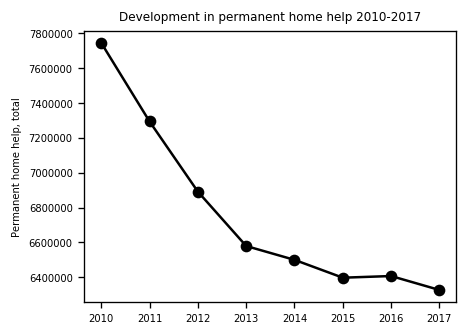

In [27]:
# a. plot figure
plt.figure(figsize=(4,3), dpi=120) 
plt.plot('year', 'home_help_total', 'ko-', data=data_denmark)

# b. ad title and labels
plt.title('Development in permanent home help 2010-2017')
plt.ylabel('Permanent home help, total')
plt.rc('font', size=6) 

The rather large decrease in the number of referral hours of home care has happened despite both the total number of persons and the fraction of the total population aged 65 and above has been steadily increasing over the time period. This is illustrated in the two figures below.

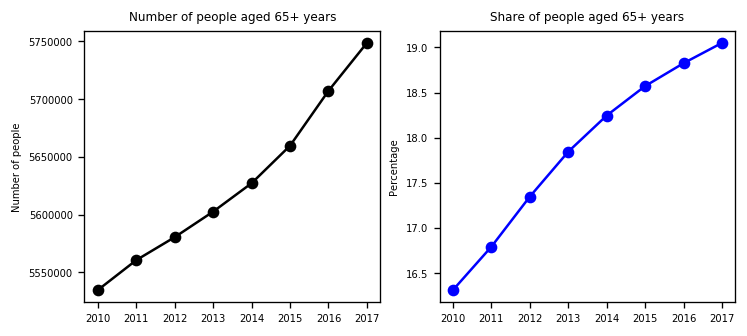

In [28]:
# a. plot figure
plt.figure(figsize=(7,3), dpi=120)

# b. specifying the left subplot
plt.subplot(1, 2, 1)
plt.plot('year', 'total', 'ko-', data=popdata)
plt.title('Number of people aged 65+ years')
plt.ylabel('Number of people')
plt.rc('font', size=6) 

# c. specifying the right subplot
plt.subplot(1, 2, 2)
plt.plot('year', 'share', 'bo-', data=popdata)
plt.title('Share of people aged 65+ years')
plt.ylabel('Percentage')
plt.rc('font', size=6) 

# d. showing the figure 
plt.show()

In the figure below the number of referral hours to home care that is chosen by the recipients to be supplied by a private contractor is a bit lower in 2017 than it was in 2010. However, the decrease in the number of referral hours to home care that is chosen to be supplied by the public has decreased a lot more from 2010 to 2017. This shows that in general a fewer number of referral hours are being supplied.

A benefit from outsourcing home care is that private companies can be more effective as well as supplying faster, better and cheaper solutions than the public (i.e. the municipality). On the other side, private companies most likely want to maximise profits, which might make private companies more focused on making the costs of home care as small as possible. This might result in private companies supplying lower quality home care. However, the municipality has to to offer its residents two or three possible contractors to provide home care, where one of them has to be the municipality itself. If the private companies drive down the quality of home care in order to maximise profit the elders can always choose a different provider (e.g. the municipality itself). This can help keep the quality of the home care provided by private companies at a certain level.

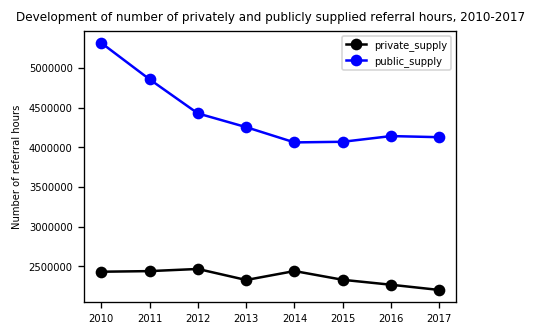

In [29]:
# a. plot figure
plt.figure(figsize=(4,3), dpi=120)
plt.plot('year', 'private_supply', 'ko-', data=data_denmark)
plt.plot('year', 'public_supply', 'bo-', data=data_denmark)

# b. ad title and labels
plt.title('Development of number of privately and publicly supplied referral hours, 2010-2017')
plt.ylabel('Number of referral hours')
plt.legend()
plt.rc('font', size=6) 

## Differences across municipalities

In this section, we first look at the development in privately and publicly supplied referral hours per person for elder aged 65 and above in the period 2010-2017. Thereafter we visualise the differences across municipalities for the total number of supplied referral hours per person for elder aged 65 and above in 2017 in a map of Danish municipalities. 

**Development in privately and publicly supplied referral hours per person**

From the figure below it is possible to see the development of the number of referral hours to home care per person in each municipality in the period 2010-2017, split on the number of hours that are supplied by the municipality and the number of hours that are supplied by a private supplier. 

Generally, most of the municipalities have experienced a decrease in the number of referral hours in total. Some municipalities, e.g. Faxe and Herlev, have experienced a shift from most of the referral hours to home care being supplied by the municipality to instead being supplied by a private supplier. Other municipalities, e.g. Hørsholm, have recipients who primarily have used private suppliers in the whole period 2010-2017. However, most municipalities have recipients who primarily have used the municipality as the supplier of home care. 

In [30]:
# defining the figure
def plot_e(dataframe, municipality): 
    I = dataframe['geo_area'] == municipality

    ax=dataframe.loc[I,:].plot(x='year', y=['private_per_pers','public_per_pers'], style=['-bo', '-ko'], figsize=(8, 5),fontsize=11, legend='False')
    ax.legend(loc='upper right', fontsize=11)
    ax.set_title('Development of number of privately and publicly supplied referral hours per person on municipality level, 2010-2017', fontsize=13)
    ax.set_xlabel('Year',fontsize=11)
    ax.set_ylabel('Number of referral hours per person', fontsize=11)

In [31]:
# making the figure interactive
widgets.interact(plot_e, 
    dataframe = widgets.fixed(data_municipality1),
    municipality = widgets.Dropdown(description='Municipality', options=data_municipality1.geo_area.unique(), value='Copenhagen')
);

interactive(children=(Dropdown(description='Municipality', index=10, options=('Aabenraa', 'Aalborg', 'Aarhus',…

**Mapping the total referral hours per person**

In this section, we map the total number of referral hours per person for elder aged 65 years and above across the municipalities in Denmark. The colouring of the map indicates an average of the total number of referral hours per person aged 65 and above in each of the municipalities. 

First, we restrict the data to only include 2017.

In [32]:
# restricting data to only include 2017
data_municipality2 = data_municipality1[data_municipality1.year == 2017]

Then we need to import a shape file for the Danish municipalities. The figure below is just a simple map of Denmark to see that the map is working properly.

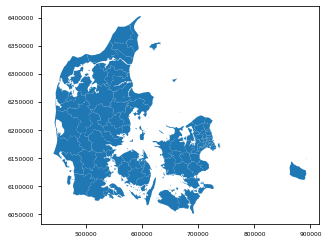

In [33]:
# a. read shape file
file = './KOMMUNE.shp'
map_df = gpd.read_file(file)

# b. plot map
map_df.plot()

Now we need to merge our data with the total referral hours per person in each municipality with the geographical data in the shape file. 

In [34]:
# a. merge on municipality
map_data = map_df.set_index('KOMNAVN').join(data_municipality2.set_index('geo_area'))

# b. look at data
map_data.head()

,FEAT_ID,FEAT_KODE,FEAT_TYPE,FEAT_STTXT,GEOM_STTXT,DAGI_ID,AREAL,REGIONKODE,REGIONNAVN,GYLDIG_FRA,...,TIMEOF_EXP,geometry,year,home_help_total,private_supply,public_supply,above64,total_per_pers,public_per_pers,private_per_pers
Aabenraa,250591,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2019-03-23,"POLYGON Z ((532245.9400000001 6079144.94 -999,...",2017.0,72066.8,31477.4512,40589.3488,13092.0,550.464406,310.03169,240.432716
Aabenraa,250589,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2019-03-23,"POLYGON Z ((532579.09 6078987.87 -999, 532579....",2017.0,72066.8,31477.4512,40589.3488,13092.0,550.464406,310.03169,240.432716
Aabenraa,250593,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2019-03-23,"POLYGON Z ((529349.23 6107743.85 -999, 529353....",2017.0,72066.8,31477.4512,40589.3488,13092.0,550.464406,310.03169,240.432716
Aabenraa,250587,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2019-03-23,"POLYGON Z ((536464.0600000001 6107571.33 -999,...",2017.0,72066.8,31477.4512,40589.3488,13092.0,550.464406,310.03169,240.432716
Aabenraa,250585,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2019-03-23,"POLYGON Z ((529191.3 6107597.05 -999, 529192.6...",2017.0,72066.8,31477.4512,40589.3488,13092.0,550.464406,310.03169,240.432716


Lastly, we choose the relevant variable we want to visualise on the map, specify the range of that variable and make some visualisation specifications related to the map. 

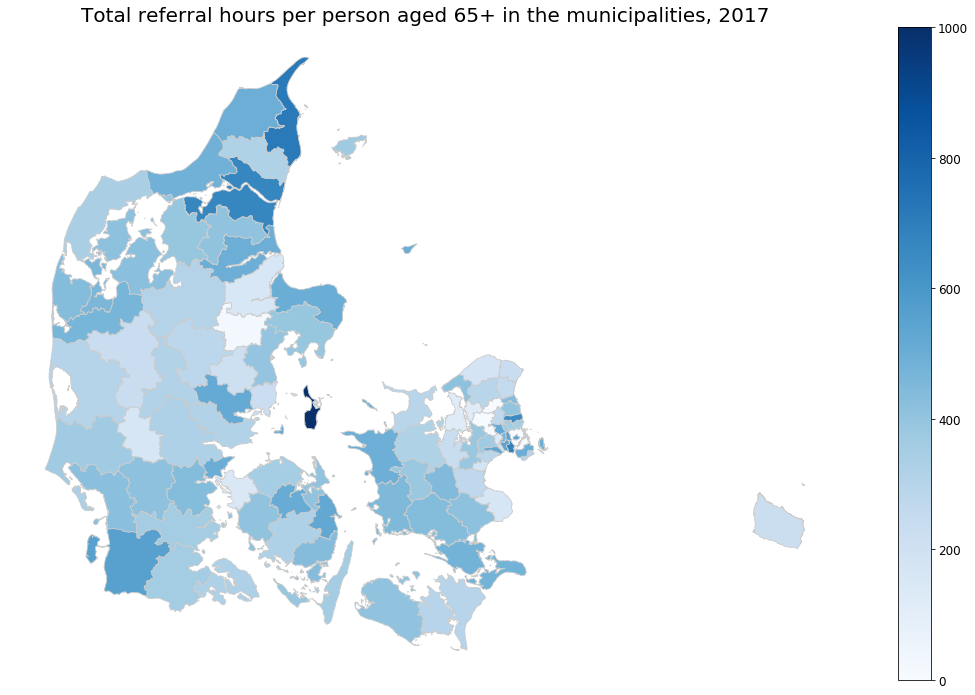

In [36]:
# a. specify the variable to visualize on the map
variable = 'total_per_pers'

# b. range of variable
vmin, vmax = 0, 1000

# c. create figure and axes 
fig, ax = plt.subplots(1,figsize=(20,12))

# d. plot the map
map_data.plot(column=variable,cmap='Blues',linewidth=0.8,ax=ax,edgecolor='0.8', legend=False)

# e. remove the axis
ax.axis('off')

# f. inserting a title to the figure
ax.set_title('Total referral hours per person aged 65+ in the municipalities, 2017', fontdict={'fontsize': '20', 'fontweight' : '3'})
           
# g. colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# h. empty array for the data range
sm._A = []

# i. Changing the font size of the colorbar
cbar = fig.colorbar(sm, ax=ax,)
cbar.ax.tick_params(labelsize=12)

From the map, it can be seen that there is a tendency that more referral hours to home care per person is being supplied in some of the rural areas, although there are a few exceptions, e.g. the relatively large city Aalborg. 

It could be that recipients living in rural areas generally have lower health status and thereby needs more home care. It could also be, that these people have had more physically demanding jobs, in contrast to the people living in urban areas, and hence, are more worn down and need more help. 

# Conclusion

In this data project, the development of referral hours to home care for the elderly in Denmark has been addressed. It has been shown that the number of people aged 65 years and above and their share of the total population has been increasing over the period 2010-2017. In the same period, the total number of referral hours to home care has been decreasing. The decrease has been largest for the hours supplied by the public, but there has also been a small decrease in the hours supplied by private contractors. Furthermore, there is a tendency that more referral hours to home care per person is being supplied in some of the rural areas of Denmark.